<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Capstone Project: Clustering Logistics Research Papers
[Part 1: Get Abstract](01_Get_Abstrast.ipynb) | [Part 2: Add Label](02_Add_Label.ipynb) | **Part 3: EDA** | [Part 4: Model Tuning](..)



---

### Import Library

In [186]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from wordcloud import WordCloud
import re

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

import deepcut
import attacut

In [187]:
df = pd.read_csv('../data/abstract_label_added.csv')
df.head()

project  \
0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4      การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม   

                                            abstract  \
0  ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...   
1  งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...   
2  ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...   
3  การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...   
4  จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...   

                                 category  \
0  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ   
1                         การจัดซื้อจัดหา   
2  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ   
3                         การจัดซื้อจัดหา   
4          การวางแผนและพยากรณ์ความต้องการ   

                                            keywords  category_id  
0  คู่มือการนำเข้าคราฟท์เบียร์, การดำเนินงานตามมา...            6  
1  การประเมินการปฏิบัติงาน, ผู้ส่งมอบ, แบ่งเกรด, ...            1  
2  Chemical Solvent, การควบคุมความปลอดภัย, รถขนส่...            6  
3  การวิจัย, กระบวนการจัดส่งใบกำกับภาษี, แผนกบัญช...            1  
4  Keywords: โควิด-19, ยานยนต์, การพยากรณ์ยอดขาย,...            5

In [5]:
df.shape

(340, 4)

In [188]:
# remove special charecters keep only and replace NaN or non-string values with empty string before applying the regex
df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'[^A-Za-z0-9\sก-ฮะ-์]', '', str(x)) if isinstance(x, str) else '')

---

### Word Tokenization

in this step, I will explore three engines to tokenize text in a list of strings and select the engine that performs the best for future processing.

**Options for engine**
1. **newmm** (default) is a dictionary-based approach that performs maximum matching, constrained by Thai Character Cluster (TCC) boundaries with improved TCC rules.

2. [**DeepCut**](https://github.com/rkcosmos/deepcut)
is a learning-based tokenization engine that leverages deep learning to segment Thai text.
3. [**AttaCut**](https://github.com/PyThaiNLP/attacut)
is another learning-based tokenization engine that offers a balance between speed and segmentation accuracy.

In [189]:
sample = ' '.join(df['abstract'][:5].to_list())

In [190]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [191]:
newmm_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine="newmm")

In [192]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

deepcut_tokenize  = word_tokenize(sample,custom_dict = custom_trie, engine="deepcut")

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [193]:
warnings.filterwarnings("ignore", category=FutureWarning)

attacut_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine='attacut')

In [194]:
# Compare each tokenizer against others
all_tokenized = {
    "newmm": set(newmm_tokenize),
    "deepcut": set(deepcut_tokenize),
    "attacut": set(attacut_tokenize),
}

print('Words in newmm but not tokenized in other engines:')
print(', '.join(all_tokenized["newmm"] - (all_tokenized["deepcut"] | all_tokenized["attacut"])))
print()

print('Words in deepcut but not tokenized in other engines:')
print(', '.join(all_tokenized["deepcut"] - (all_tokenized["newmm"] | all_tokenized["attacut"])))
print()

print('Words in attacut but not tokenized in other engines:')
print(', '.join(all_tokenized["attacut"] - (all_tokenized["newmm"] | all_tokenized["deepcut"])))

Words in newmm but not tokenized in other engines:
จัดการ, เป็นไปตาม, ความสำคัญ, ความร่วมมือ, สายไฟฟ้า, แนว, คงคลัง, มากขึ้น, มีความสำคัญ, ใบกำกับภาษี, ที่ชัดเจน, จัดกลุ่ม, การบริหาร, ความสามารถ, กลุ่มตัวอย่าง, ขีดความสามารถ, ข้อบกพร่อง, ประยุกต์ใช้, ผู้จัดทำ, มูล, ในอนาคต, ผู้ประกอบการ, สายไฟ, รวมถึง, ส่วนประกอบ, ทำการ, ที่จะ, การจัดซื้อจัดหา, แรงจูงใจ, เนื่องจาก, การวิจัย, ผู้ส่งมอบ, ส่วนหนึ่ง, ปัจจัยหลัก, จัดจำหน่าย, สั่งซื้อ, ตามลำดับ, หลังจากที่, การเขียน, จัดเก็บ, เป็นไป, การนำเข้า, ทำงาน, ยอดขาย, ความปลอดภัย, อาจจะ, คราฟท์เบียร์, ความต้องการ, เชื้อไวรัส, เพลิงไหม้, ที่เกี่ยวข้อง, การคำนวณ, ดำเนินงาน, การดำเนินการ, ทำให้, ทางการ, ปรับปรุงแก้ไข, ความเหมาะสม, รายการสินค้า, ต่างประเทศ, การขับรถ, คลังสินค้า, ความพึงพอใจ, การประเมิน, ดังกล่าว, ดังนั้น, ภายใน, ด้านการบริหาร, ให้กำลังใจ, อย่างชัดเจน, ร่วมกับ, แบบทดสอบ, รายเดือน, แบบประเมิน, แพร่ระบาด, การจัดทำ, เดียวกัน, การศึกษา, ผู้วิจัย, การผลิต, คนขับรถ, มีประสิทธิภาพ, การขนส่ง, จัดลำดับ, ความคลาดเคลื่อน, ได้รับ, โร, ความสนใจ, ฐานนิ

In [195]:
# The default engine (newmm) performs better than the other engines.

---

### Exploratory and Explanatory Data Analysis

**Abstract Length & Abstract Word Count**

In [196]:
def tokenizer(text):
    return len(word_tokenize(text,custom_dict = custom_trie, engine="newmm"))

In [197]:
df['abstract_length'] = df['abstract'].apply(lambda x: len(x))    

In [198]:
df['abstract_word_count'] = df['abstract'].apply(tokenizer)     

In [199]:
df.head()

project  \
0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4      การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม   

                                            abstract  \
0  ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...   
1  งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...   
2  ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...   
3  การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...   
4  จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...   

                                 category  \
0  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ   
1                         การจัดซื้อจัดหา   
2  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ   
3                         การจัดซื้อจัดหา   
4          การวางแผนและพยากรณ์ความต้องการ   

                                            keywords  category_id  \
0  คู่มือการนำเข้าคราฟท์เบียร์, การดำเนินงานตามมา...            6   
1  การประเมินการปฏิบัติงาน, ผู้ส่งมอบ, แบ่งเกรด, ...            1   
2  Chemical Solvent, การควบคุมความปลอดภัย, รถขนส่...            6   
3  การวิจัย, กระบวนการจัดส่งใบกำกับภาษี, แผนกบัญช...            1   
4  Keywords: โควิด-19, ยานยนต์, การพยากรณ์ยอดขาย,...            5   

   abstract_length  abstract_word_count  
0              859                  170  
1             1172                  258  
2             1964                  383  
3             1252                  264  
4             1924                  478

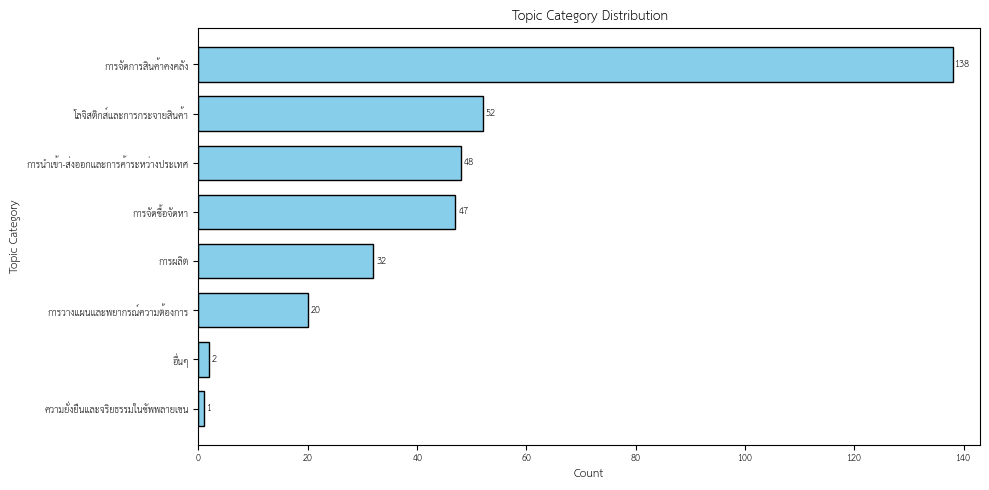

In [202]:
# Create a bar chart
topic_counts = df['category'].value_counts().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(topic_counts.index, topic_counts.values, color='skyblue', edgecolor='black', height=0.7)

# Add values to the bars, with dynamic positioning to avoid overlap
for bar in bars:
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    # Adjust the position of the labels to avoid overlap
    ax.text(bar_width + 0.5, bar_y, str(bar_width),
            va='center', ha='left', fontsize=10, color='black')

# Customize the chart
ax.set_title('Topic Category Distribution', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Topic Category', fontsize=12)
ax.set_xlim(0, max(topic_counts.values) + 5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/topic_category_distribution.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

In [201]:
# Save cleaned dataframe to next process
df.to_csv('../data/cleaned_abstract.csv', index=False)

---

### Check Common word in each topic category

In [20]:
thai_stopwords_list = ' '.join(thai_stopwords()).split()

In [21]:
# Define a custom tokenizer function that only matches Thai alphabet characters
def clean_tokenizer(text):
    thai_english_text = re.sub(r'[^ก-๙ก-ฮa-zA-Z\s]', '', text)
    words_list = word_tokenize(thai_english_text, custom_dict=custom_trie, engine="newmm")
    words_list_cleaned = [word.strip() for word in words_list if word not in thai_stopwords_list]
    return words_list_cleaned

In [142]:
# Initialize the CountVectorizer with a custom token_pattern and stop words list
cvec = CountVectorizer(
    tokenizer=clean_tokenizer,  # Custom tokenizer
    token_pattern=None
)

# Fit and transform the text data
X = cvec.fit_transform(df['abstract']).todense()  # Fitting and transforming
df_X = pd.DataFrame(X, columns=cvec.get_feature_names_out())  # Create DataFrame with words as columns
df_X.head()

df_X_pc = pd.concat([df['category'], df_X.drop(columns= '')], axis = 1).groupby('category').sum()
df_X_pc.T.head()

topic_category  การจัดการสินค้าคงคลัง  การจัดซื้อจัดหา  \
a                                  24                3   
aa                                  3                0   
ab                                  3                0   
abc                                38                3   
able                                2                0   

topic_category  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ  การผลิต  \
a                                                    0        4   
aa                                                   0        0   
ab                                                   0        0   
abc                                                  0        1   
able                                                 0        0   

topic_category  การวางแผนและพยากรณ์ความต้องการ  \
a                                            7   
aa                                           0   
ab                                           0   
abc                                          6   
able                                         0   

topic_category  ความยั่งยืนและจริยธรรมในซัพพลายเชน  อื่นๆ  \
a                                                1      0   
aa                                               0      0   
ab                                               0      0   
abc                                              0      0   
able                                             0      0   

topic_category  โลจิสติกส์และการกระจายสินค้า  
a                                          6  
aa                                         0  
ab                                         0  
abc                                        2  
able                                       0

In [145]:
df_with_avg.drop(columns = 'avg_word_frequencies', inplace = True)

In [146]:
# Set the Thai font (you can replace 'TH SarabunPSK' with any Thai font installed on your system)
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

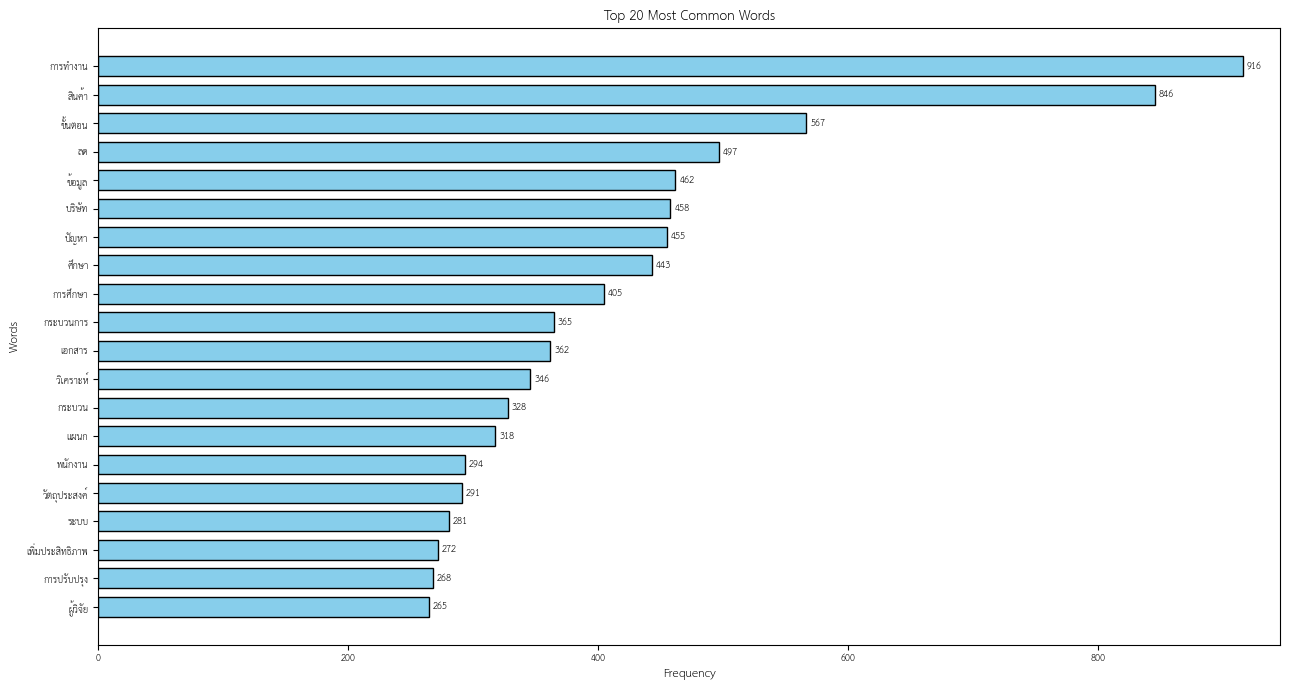

In [181]:
# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(13, 7))

# Generate the horizontal bar chart
bars = ax.barh(df_top_words.index, df_top_words.values, color='skyblue', edgecolor='black', height=0.7)

# Add values to the bars with dynamic positioning to avoid overlap
for bar in bars:
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    # Adjust the position of the labels to avoid overlap
    ax.text(bar_width + 3, bar_y, str(bar_width),
            va='center', ha='left', fontsize=10, color='black')

# Customize the chart
ax.set_title('Top 20 Most Common Words', fontsize=14)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Words', fontsize=12)
ax.set_xlim(0, max(df_top_words.values) + 30)  # Use df_top_words.values for consistency

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/category_paper_counts.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

### WordCloud

In [144]:
avg_word_frequencies = df_X_pc.T.mean(axis=1)
df_with_avg = df_X_pc.T.copy()  # Copy the original DataFrame
df_with_avg['avg_word_frequencies'] = avg_word_frequencies
df_with_avg.iloc[:, 0:8] = df_with_avg.iloc[:, 0:8].sub(df_with_avg.iloc[:, 8], axis=0)
df_with_avg.head()

topic_category  การจัดการสินค้าคงคลัง  การจัดซื้อจัดหา  \
a                              18.375           -2.625   
aa                              2.625           -0.375   
ab                              2.625           -0.375   
abc                            31.750           -3.250   
able                            1.750           -0.250   

topic_category  การนำเข้า-ส่งออกและการค้าระหว่างประเทศ  การผลิต  \
a                                               -5.625   -1.625   
aa                                              -0.375   -0.375   
ab                                              -0.375   -0.375   
abc                                             -6.250   -5.250   
able                                            -0.250   -0.250   

topic_category  การวางแผนและพยากรณ์ความต้องการ  \
a                                        1.375   
aa                                      -0.375   
ab                                      -0.375   
abc                                     -0.250   
able                                    -0.250   

topic_category  ความยั่งยืนและจริยธรรมในซัพพลายเชน  อื่นๆ  \
a                                           -4.625 -5.625   
aa                                          -0.375 -0.375   
ab                                          -0.375 -0.375   
abc                                         -6.250 -6.250   
able                                        -0.250 -0.250   

topic_category  โลจิสติกส์และการกระจายสินค้า  avg_word_frequencies  
a                                      0.375                 5.625  
aa                                    -0.375                 0.375  
ab                                    -0.375                 0.375  
abc                                   -4.250                 6.250  
able                                  -0.250                 0.250

In [152]:
word_count_df = pd.DataFrame({
    'word': df_X.sum().index,
    'count': df_X.sum().values
})
word_count_df = word_count_df[word_count_df['word']!= ''] #remove blank
word_count_dict = dict(zip(word_count_df['word'], word_count_df['count']))

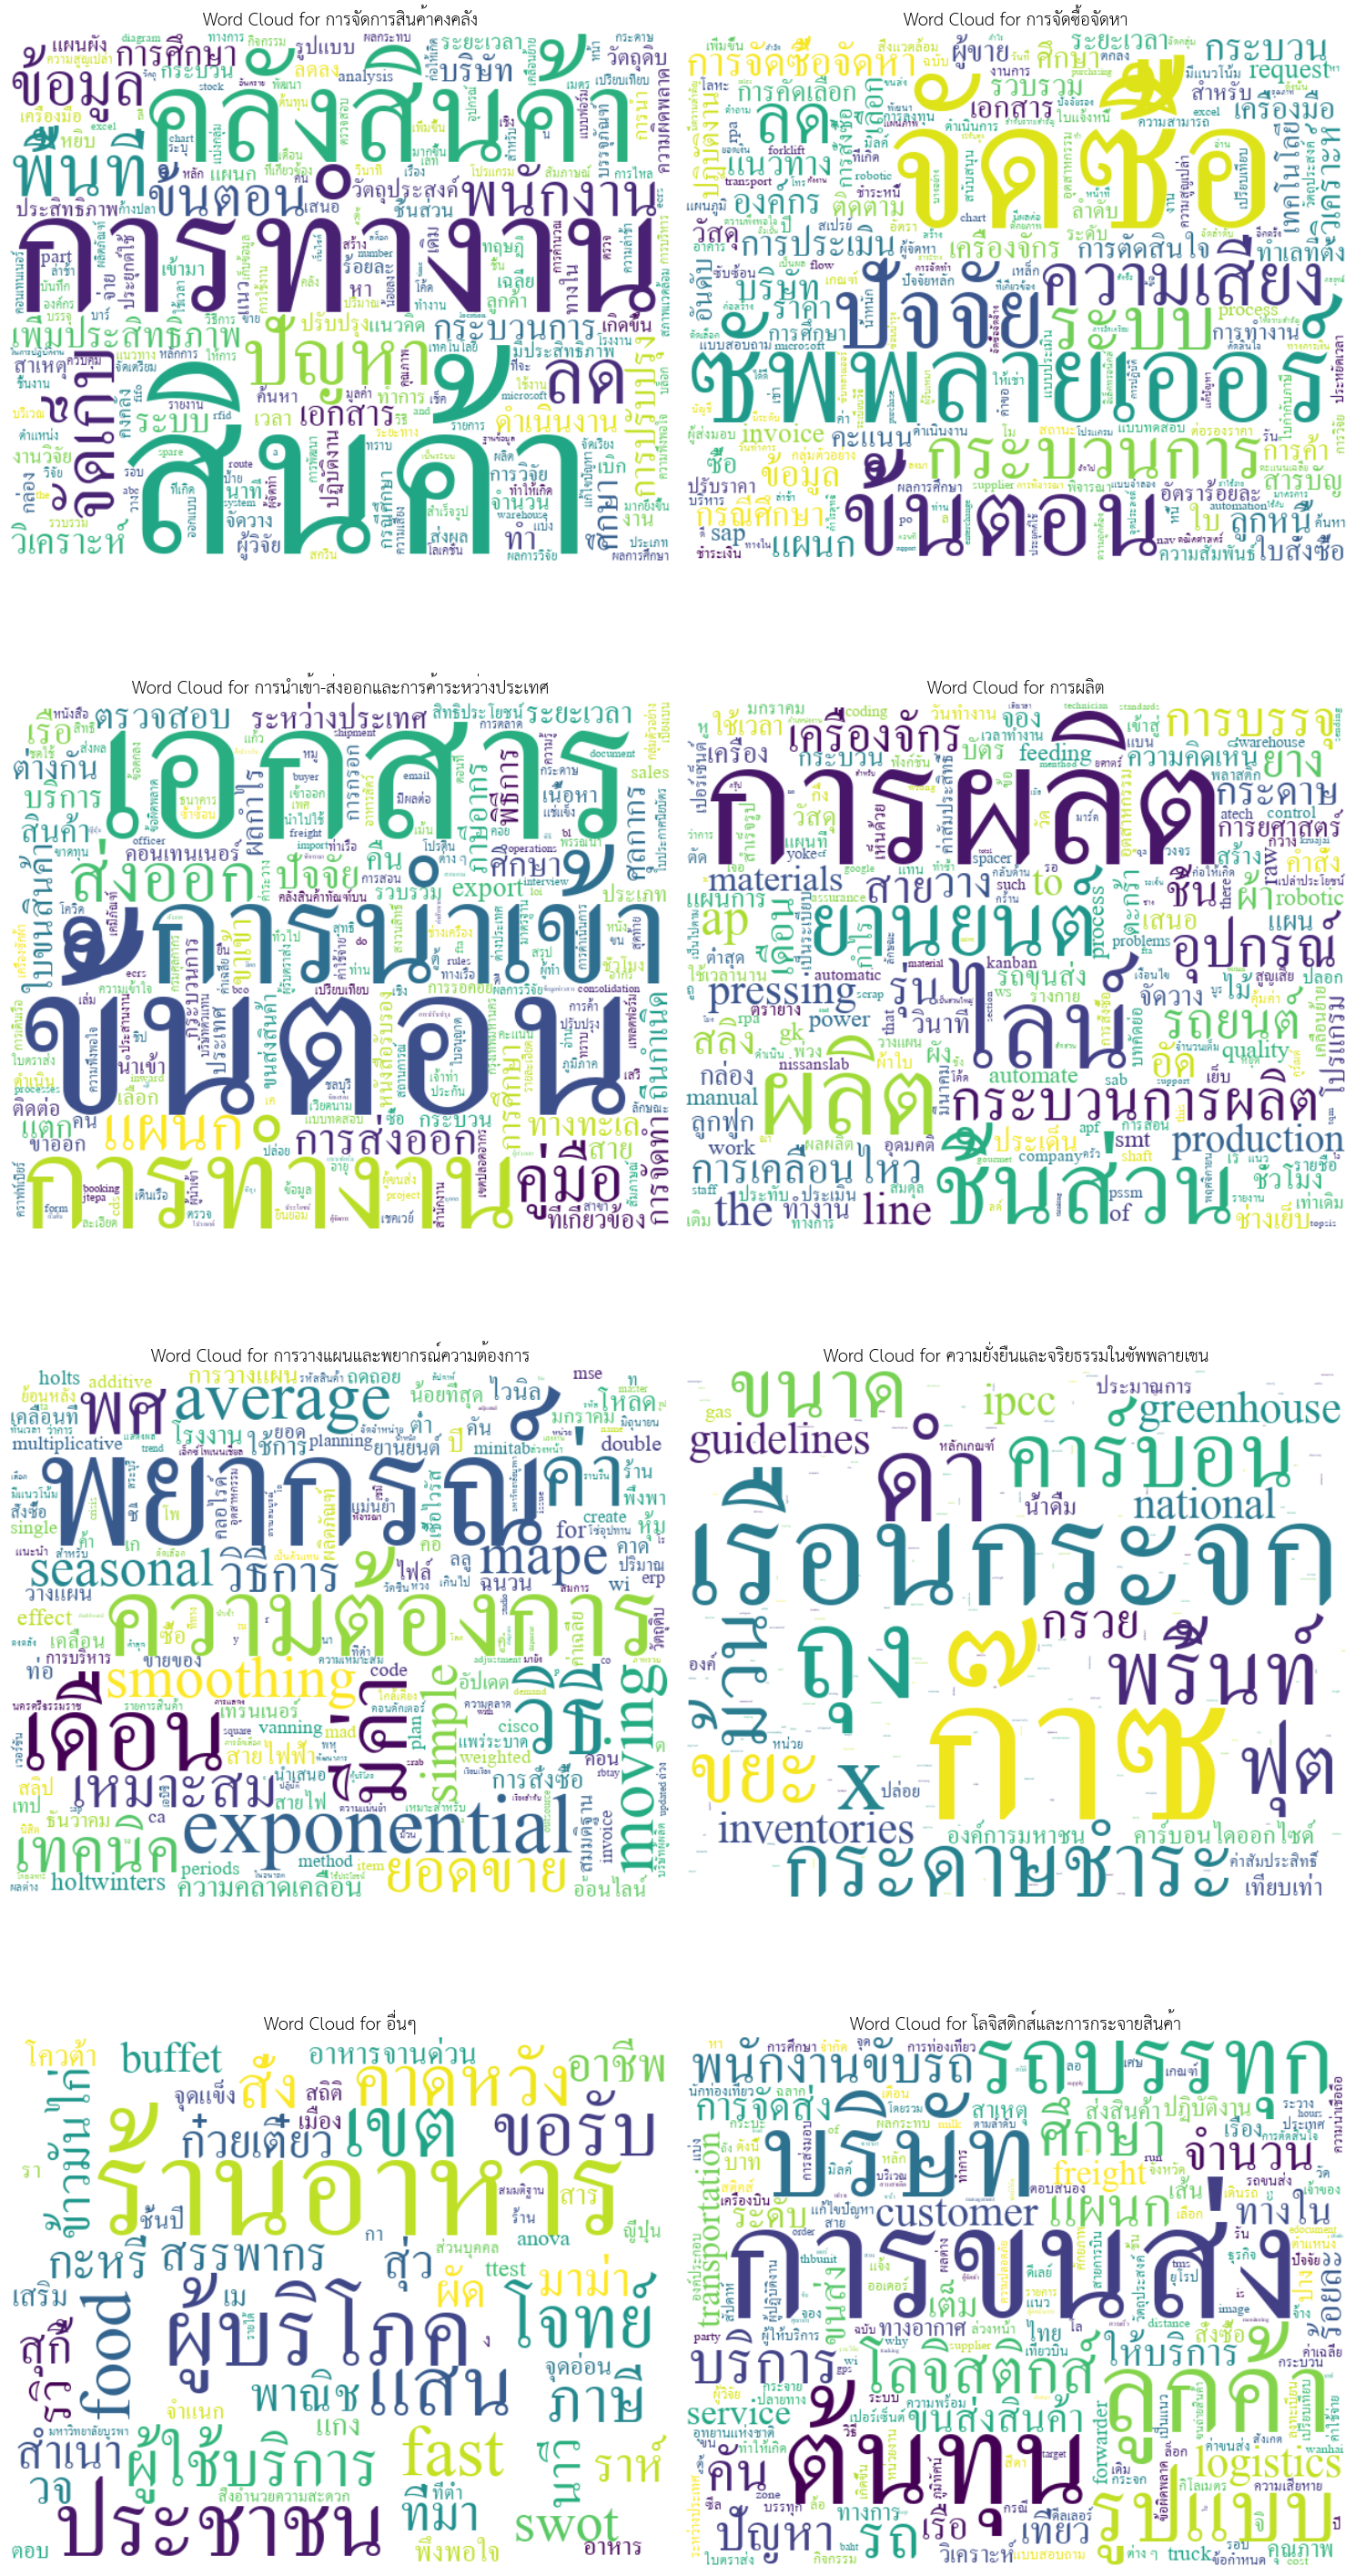

In [185]:
# Path to Thai font (change this path based on where you store the font on your machine)
thai_font_path = 'content/angsana.ttc'

# Create a figure with 4 rows and 2 columns for subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

# Flatten the 2D axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through the columns of df_with_avg and generate word clouds
for i, col in enumerate(df_with_avg.columns):
    cats = dict(zip(df_with_avg.index, df_with_avg[col]))
    
    # Generate WordCloud for Thai text
    wordcloud = WordCloud(width=600, 
                          height=480, 
                          background_color='white',
                          font_path=thai_font_path).generate_from_frequencies(cats)
    
    # Plot the word cloud in the corresponding subplot
    ax = axes[i]  # Get the flattened subplot corresponding to the column
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Word Cloud for {col}', fontsize=20)
    
plt.tight_layout()

# Show the plot
plt.show()